In [10]:
%pip install laspy
%pip install open3d


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import laspy
from laspy import CopcReader, Bounds
import open3d as o3d

import ellipsis as el
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

In [12]:
pointcloud = 'input-data/WadeyeNT.las'

The first step for getting started with laspy is to read a file using the laspy.read() which will give you a LasData object with all the LAS/LAZ content of the source file parsed and loaded.This function reads all the data in the file into memory.

In general, point dimensions are accessible as properties of the main file object, and header attributes are accessible via the header property of the main file object.

LAS files differ in what data is available, and you may want to check out what the contents of your file are. Laspy includes several methods to document the file specification, based on the PointFormat.

In [13]:
with laspy.open(pointcloud) as fh:
    print('Point from header:', fh.header.point_count)
    las = fh.read()
    print('Points from data:', len(las.points))
    point_format = las.point_format
    print('Number of dimensions in this als file: {}'.format(point_format))
    print('Names of dimensions in las file:')
    print(list(point_format.dimension_names))

Point from header: 2058153
Points from data: 2058153
Number of dimensions in this als file: <PointFormat(7, 0 bytes of extra dims)>
Names of dimensions in las file:
['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']


Many tasks require finding a subset of a larger data set. Luckily, numpy makes this very easy. For example, suppose we’re interested in finding out whether a file has accurate min and max values for the X, Y, and Z dimensions.

In [14]:
# Get arrays which indicate invalid X, Y, or Z values.
X_invalid = (las.header.mins[0] > las.x) | (las.header.maxs[0] < las.x)
Y_invalid = (las.header.mins[1] > las.y) | (las.header.maxs[1] < las.y)
Z_invalid = (las.header.mins[2] > las.z) | (las.header.maxs[2] < las.z)
bad_indices = np.where(X_invalid | Y_invalid | Z_invalid)

print(bad_indices)

(array([], dtype=int64),)


As you can see, having the data in numpy arrays is very convenient. Even better, it allows one to dump the data directly into any package with numpy/python bindings. For example, if you’re interested in calculating the nearest neighbors of a set of points, you can use scipy’s KDTtree (or cKDTree for better performance)

In [15]:
# Grab a numpy dataset of our clustering dimensions:
dataset = np.vstack((las.X, las.Y, las.Z)).transpose()
# Build the KD Tree
tree = cKDTree(dataset)
# This should do the same as the FLANN example above, though it might
# be a little slower.
neighbors_distance, neighbors_indices = tree.query(dataset[100], k=5)
print(neighbors_indices)
print(neighbors_distance)

[100 101 102 105 103]
[   0.          655.7232648  1048.44551599 1176.16580464 1301.18138628]


For another example, lets say we’re interested only in the last return from each pulse in order to do ground detection. We can easily figure out which points are the last return by finding out for which points return_num is equal to num_returns.

Since the data are simply returned as numpy arrays, we can use all sorts of analysis and plotting tools. For example, if you have matplotlib installed, you could quickly make a histogram of the intensity dimension.

2058153 points out of 2058153 were ground points.


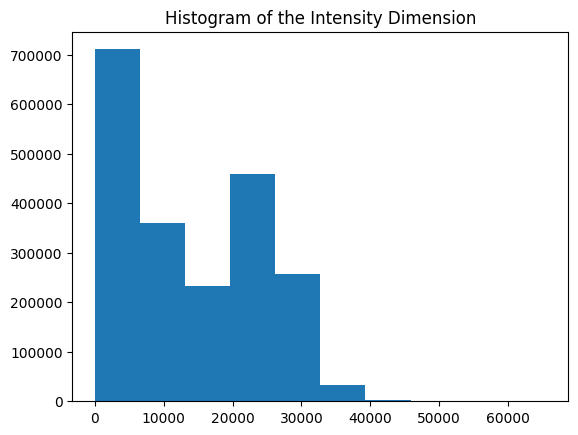

In [16]:
# Grab the return_num and num_returns dimensions
ground_points = las.points[las.number_of_returns == las.return_number]

print("%i points out of %i were ground points." % (len(ground_points),
        len(las.points)))
plt.hist(las.intensity)
plt.title("Histogram of the Intensity Dimension")
plt.show()

To visualise the point cloud we need to extract the X,Y,Z dimensions and put them into a numpy array first.

In [17]:
# preparation for visualization
points = np.vstack((las.x, las.y, las.z)).transpose()
print(points.shape)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

(2058153, 3)


In [ ]:
o3d.visualization.draw_geometries([pcd])